---
title: Dimensionality Reduction
format:
    html:
        code-fold: true
---

## Project Proposal

So, for the dimensionality reduction section I will once again be using the Ravely dataset I've been working on in order to create an index for popularity of a pattern. There are a couple measures I've looked at before such as number of comments, favorites, projects, and ratings all which point towards popularity but each don't have a whole story.

I will be using scikit learn packages with both the PCA and T-SNE properties attached to them. The methods are fairly self-contained so I don't expect to need many other packages other than the basics like numpy, pandas, and matplotlib.

## Principal Component Analysis

I will be establishing the data for the analysis, creating pair plots to see correlation, running a component analysis, visualizing increases in explained variance using an area plot, and visualizing the data on the first couple of components. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pattern_df = pd.read_csv("../data/pattern_data_updated.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96309 entries, 0 to 96308
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comments_count         96309 non-null  int64  
 1   favorites_count        96309 non-null  int64  
 2   projects_count         96309 non-null  int64  
 3   queued_projects_count  96309 non-null  int64  
 4   rating_count           96309 non-null  int64  
 5   rating_average         96309 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 4.4 MB


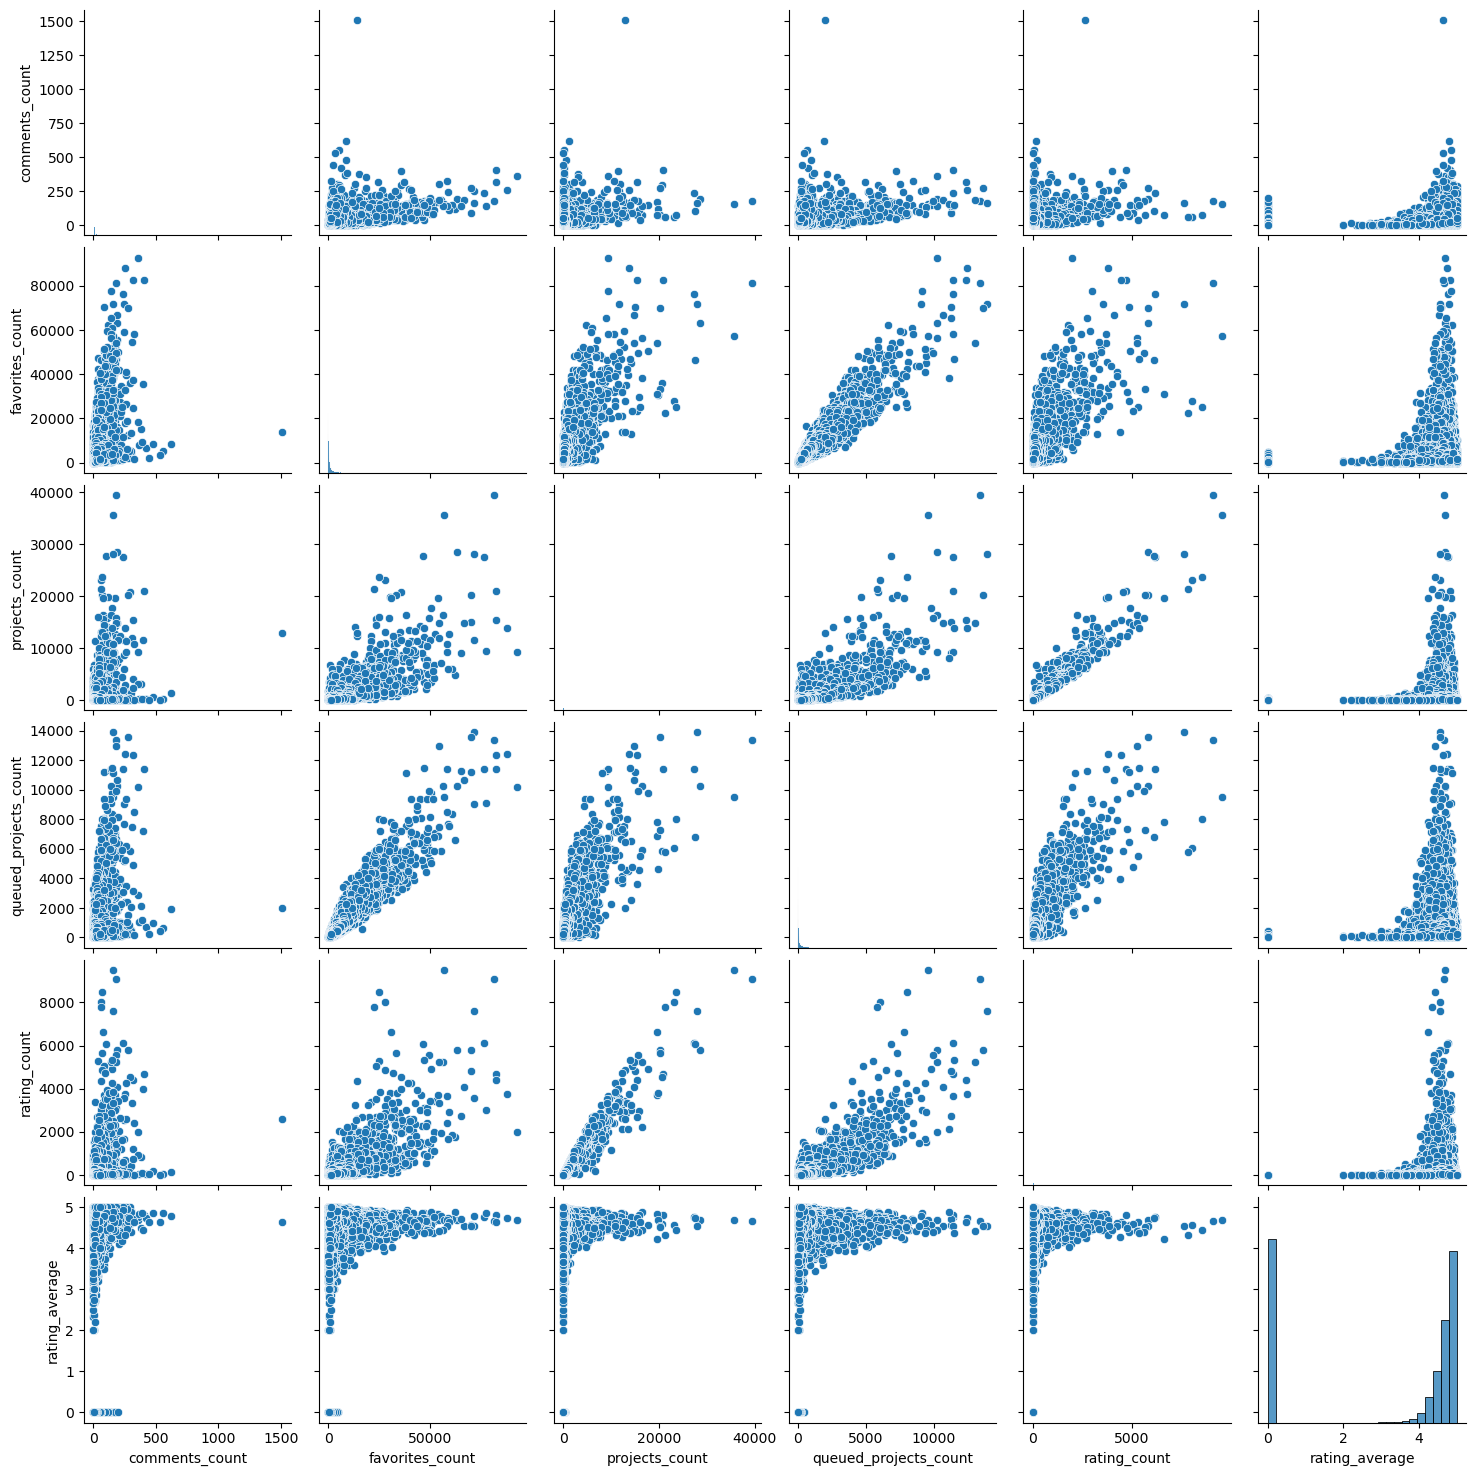

In [2]:
df_popularity = pattern_df[["comments_count","favorites_count","projects_count","queued_projects_count","rating_count","rating_average"]]

## this is okay cause a null rating count means it hasn't been rated yet
df_popularity = df_popularity.fillna(0)

df_popularity.info()

sns.pairplot(df_popularity)

There definitely seems to be some linear behavior between project counts and favorites as well as ratings and counts. This would be a good sign for a regression model let alone a Principal Component Analysis approach so I'm looking forward to our results.

In [4]:
## running PCA
df_popularity = pattern_df[["comments_count","favorites_count","projects_count","queued_projects_count","rating_count","rating_average"]]

## this is okay cause a null rating count means it hasn't been rated yet
df_popularity = df_popularity.fillna(0)

from sklearn.decomposition import PCA
n = 5
pca = PCA(n_components=n)
pca.fit(df_popularity)
print('\nPCA')

for i in range(0,n):
    print("\nPCA components:")
    print(pca.components_[[i]])
    print("PCA explained variance:")
    print(pca.explained_variance_ratio_[i])



PCA

PCA components:
[[3.21895085e-03 9.79748260e-01 1.37850803e-01 1.39657353e-01
  3.96980251e-02 1.79585923e-04]]
PCA explained variance:
0.9816818513379555

PCA components:
[[-9.98049192e-06 -1.65318331e-01  9.38926887e-01  1.60301921e-01
   2.55713078e-01 -5.16136294e-04]]
PCA explained variance:
0.016759553546169

PCA components:
[[ 0.00101344 -0.11158473 -0.21643561  0.9625503   0.11916108 -0.00100661]]
PCA explained variance:
0.001435235907577648

PCA components:
[[-0.02558237  0.01746727 -0.22919575 -0.16810798  0.9582444   0.00413871]]
PCA explained variance:
0.00010434441598611692

PCA components:
[[ 0.99961428 -0.00260078 -0.00606786 -0.00570794  0.02423672  0.01037805]]
PCA explained variance:
1.8569747238803367e-05


In [5]:
## I'm using some visualizations for understanding from the following website:
# https://plotly.com/python/pca-visualization/
import plotly.express as px

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

The figures were having trouble rendering so I am adding a image in here:

!["Image of increased explained variance over #components"](../images/PCA%20components.png)

In [6]:
features = df_popularity.columns

import plotly.express as px

components = pca.fit_transform(df_popularity)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1)

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

!["Plot of components of data"](../images/newplot.png)

The results of the PCA show a really strong first component which can detect most of the variance. This is good in my case and expected since most of the variables are highly correlated as seen in the pair plot above. The last visualization isn't wildly helpful as the dimensions of the data are fairly one note and the arrows close together due to the size of the data. Now let's apply the components to the data and see which pattern is the most popular.


In [50]:
primary_c = pca.components_[0]

popularity_tally = []
for i in range(0,df_popularity.shape[0]):
    rowsum = 0
    for g in range(0,5):
        rowsum = rowsum + (primary_c[g]*df_popularity.iloc[i,g])
    popularity_tally.append(rowsum)

print(popularity_tally[0:10])
popularity_tally = pd.DataFrame(popularity_tally)

[762.9659133011417, 701.6150108970547, 606.8493714140815, 253.0165335569481, 503.42293460566384, 57.240417793649456, 62.14311242900399, 600.0041196829263, 138.38090774266988, 50.94476272476789]


In [56]:
components_df = pd.DataFrame(components)
popularity_score = components_df.sum(axis = 1)

pop_score = pd.concat([pattern_df["name"],popularity_score], axis = 1)
pop_score.rename(columns = {0:"score"},inplace = True)

pop_score = pd.concat([pop_score,popularity_tally], axis = 1)
pop_score.rename(columns = {0:"tally"},inplace = True)

print(pop_score.sort_values("score").head())
print(pop_score.sort_values("score").tail())


                                   name        score     tally
14555               Storm Warming Toque -1300.871745  0.137851
50542  Furballs' Ticky Tabby Hat 蜱斑大花貓帽 -1300.871745  0.137851
15303      Malizia-Roses Baby Hat (#34) -1300.871745  0.137851
34483                     Baby Doll Hat -1300.871745  0.137851
79019            Super Bulky HDC Beanie -1300.871745  0.137851
                          name          score         tally
75               The Weekender   89486.149212  89960.159960
77                  Ranunculus   90336.365962  85476.080862
74                        Flax   91899.319123  80512.648496
448                 Honey Cowl   93646.231565  76507.825359
151  Hermione's Everyday Socks  109075.391802  87302.574573


There are around 26 patterns with the absolute lowest score of -1300.154034 in terms of the PCA transformation score. I wasn't sure what that function to get the scores was doing so I did a test by hand using just the first principal component and got a very similar tally for most of the numbers. The top five are pretty much the same with Hermoine's Everyday Socks being the objectively most popular pattern and storm warning toque and the other 25 being the least popular. This is funny because this sock pattern is just very average and seems to just have caught on by being a least common denominator sock pattern.



## TSNE

I don't know if this will work as well for my goals as this method is more about visualization. I may try a couple processes to see if there is a perplexity which makes more sense but for now it is a dry run to see if the method is possible to use with the data.

I will take a few fewer steps for this analysis and just run the model and visualize the results.

In [7]:
from sklearn.manifold import TSNE

print(df_popularity.shape)

df_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=30).fit_transform(df_popularity)


(96309, 6)


RESULTS
shape :  (96309, 3)
First few points : 
 [[  0.72771114 -11.23116      7.6040716 ]
 [-13.847262   -26.378683    13.738866  ]]


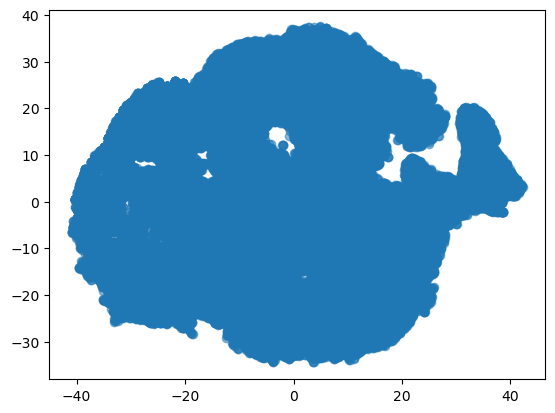

In [8]:

print("RESULTS") 
print("shape : ",df_embedded.shape)
print("First few points : \n",df_embedded[0:2,:])

plt.scatter(df_embedded[:,0],df_embedded[:,1], alpha=0.5)
plt.show()

This and other visualizations were not nearly as helpful as hoped. It visualizes the data but does not provide much insight.

## Project Report

I will mostly be mentioning visualizations and values from the previous sections so there will not be much added information here.

So as mentioned before the steps I used followed the structure of the models; running a PCA analysis and looking through the components as well as visualizing the dimensionality reduction with TSNE. The results of both of those were weights for the different variables for the former and a map that looks something like Antarctica on the latter. 

My analysis of the PCA is that the primary component seems like the one I should use for the index as it represents the vast majority of the variability in the data and I'm sure it will be successful in finding the most popular pattern when I apply it to the data. I think the strong performance of this component is due to the preexisting correlation, which makes sense as if a pattern has more favorites then it's more likely to be made into a project or commented on and vice versa with the whole mess.

My analysis of the TSNE is harder to clarify as the graph I had was not as helpful in discerning the true nature of the data. I'm not sure if this method will be as helpful since I'm not looking for groups in the data but rather a linear trend of popularity. I do think its cool that the map looks like Antarctica though.

Anyhow, I think the PCA had a stronger use case but the TNSE was an interesting model to compare and adapt to.

